**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [19]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar, minimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
from scipy.optimize import root_scalar

#from scipy import optimize
#import pandas as pd 

sm.init_printing(use_unicode=True) # for pretty printing
#from IPython.display import display
#import ipywidgets as widgets
#from types import SimpleNamespace
#from copy import deepcopy

# Autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

In [20]:
# Defining baseline parameters:
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.30

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We verify this by using the Lagrangian method. We begin by defining the Lagrangian function:
$$\mathcal{L}(C,G,L,\lambda)=\ln(C^{\alpha}G^{1-\alpha})-\nu\frac{L^{2}}{2}+\lambda\left[\kappa+(1-\tau)wL-C\right]$$
We find the FOC wrt. $L$ by setting the derivative of the function equal to $0$:
$$\frac{\partial \mathcal{L}}{\partial L} = 0$$
$$\Rightarrow \lambda(1-\tau)w - \nu L = 0$$
$$\Rightarrow \lambda(1-\tau)w  = \nu L$$
$$\Rightarrow L = \frac{\lambda(1-\tau)w}{\nu}$$
Then, we find the expression for $C$:
$$C=\kappa+(1-\tau)wL = \kappa+(1-\tau)w\frac{\lambda(1-\tau)w}{\nu} $$
As $\tilde{w} = (1-\tau)w$, we get:
$$C=\kappa+\tilde{w}L = \kappa+\tilde{w}\frac{\lambda(\tilde{w})}{\nu} $$

$$\Rightarrow \lambda = \frac{\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}-\kappa}{2\tilde{w}}$$

Which result in:
$$L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}}{2\tilde{w}}$$
Hereby, it is vertified that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha G}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

We use the expression for $L^{\star}(\tilde{w})$ to illustrate how the optimal labor supply choice depends on $w$ for different values of $G$. 

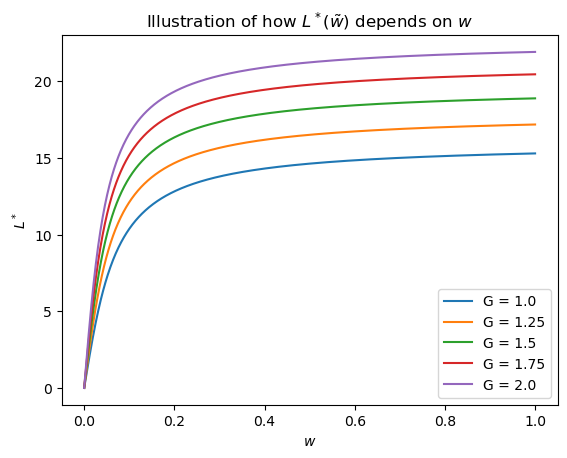

In [21]:
# Defining function for optimal labor supply
def L_star(w, G):
    return (-kappa + np.sqrt(kappa**2 + 4*alpha*G/(nu)*((1-tau)*w)**2))/(2*((1-tau)*w))

# Defining a range of values for tilde_w
w_values = np.linspace(0.000001, 1, 1000)

# Defining values for G
G_values = [1.0, 1.25, 1.5, 1.75, 2.0]

# Plotting L_star as a function of tilde_w for different values of G
for G in G_values:
    L_values = L_star(w_values, G)
    plt.plot(w_values, L_values, label='G = {}'.format(G))

# Adding axis labels and legend
plt.xlabel('$w$')
plt.ylabel('$L^*$')
plt.title('Illustration of how $L^*(\\tilde{w})$ depends on $w$')
plt.legend()

# Show plot
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We find the labor supply $L^{\star}$, government consumption $G$, and worker utility $V(w,\tau,G)$ for different values of $\tau$. Afterwards, we plot all three variables against $\tau$.

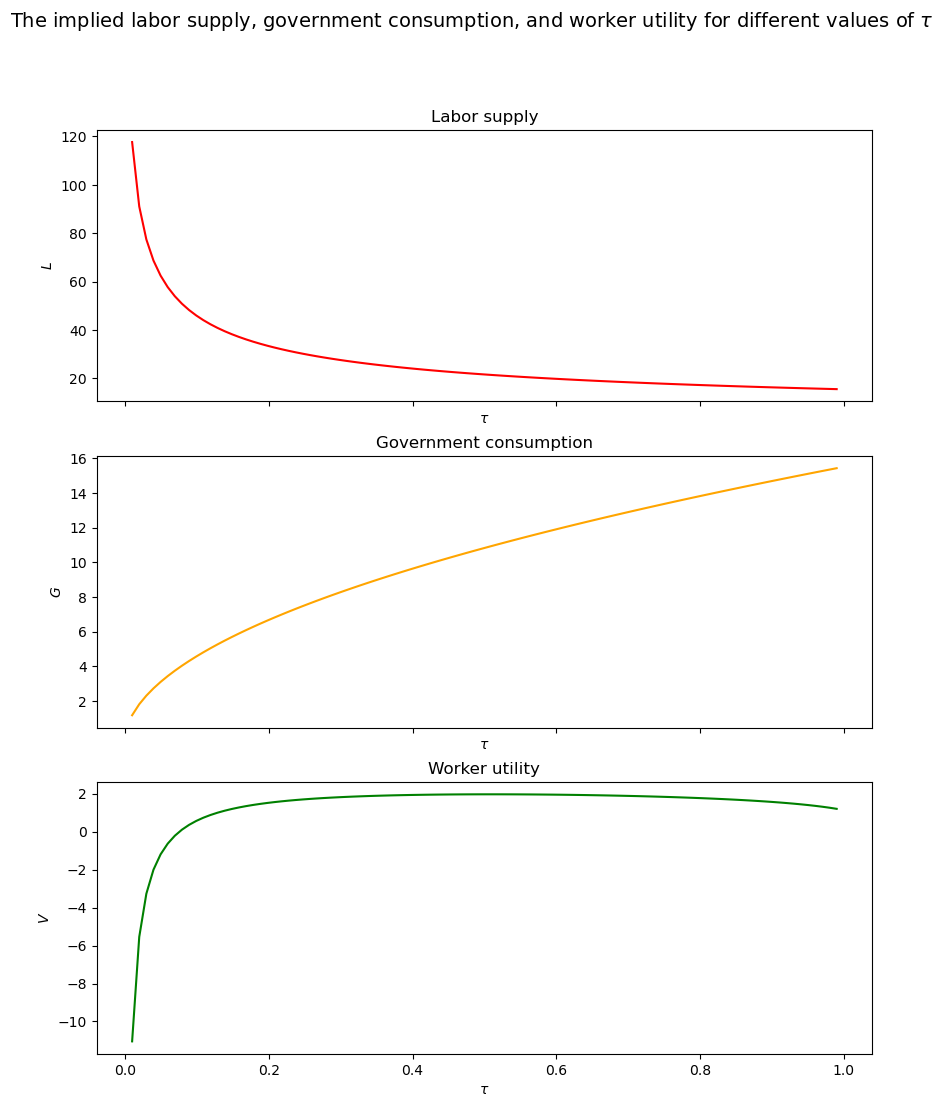

In [22]:
# Defining function for optimal labor supply
def L_star(tau, w):
    return (-kappa+np.sqrt(kappa**2+4*alpha*tau*w**2/nu))/(2*tau*w)

# Defining function for government consumption
def G(tau, w):
    return tau*w*L_star(tau, w)

# Defining function for worker utility
def utility(tau, w):
    L = L_star(tau, w)
    C = kappa+(1-tau)*w*L
    return np.log(C**alpha*G(tau, w)**(1-alpha))-nu*L**2/2

# Defining a range of values for tau
tau_values = np.linspace(0.01, 0.99, 100)

# Calculating optimal labor supply, government consumption, and worker utility for different values of tau
L_values = L_star(tau_values, w)
G_values = G(tau_values, w)
utility_values = utility(tau_values, w)

# Plot results
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,12))
fig.suptitle('The implied labor supply, government consumption, and worker utility for different values of $\\tau$', fontsize=14)
ax[0].plot(tau_values, L_values, color='red')
ax[0].set_ylabel('$L$')
ax[0].set_xlabel('$\\tau$')
ax[0].set_title('Labor supply')
ax[1].plot(tau_values, G_values, color='orange')
ax[1].set_ylabel('$G$')
ax[1].set_xlabel('$\\tau$')
ax[1].set_title('Government consumption')
ax[2].plot(tau_values, utility_values, color='green')
ax[2].set_ylabel('$V$')
ax[2].set_xlabel('$\\tau$')
ax[2].set_title('Worker utility')
plt.show()

The plot shows that when labor-income tax rate is close to 0, labor supply is high, government consumption is low and worker utility is low. This is because there is incentive to work as the workers keep a bigger part of their wage, but as the tax rate is low, government does not have an income and cannot consume. Worker utility is low, which can be explained by government not being able to provide public goods for the workers. As the labor-income taxe rate increases, labor supply decreases, government consumption increases, and worker utility increases to a certain point, but if the tax rate is too high, worker utility begins to decrease as a too high income-tax reduces incentive to work.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [23]:
# Define the utility function
def utility(L, tau):
    C = kappa+(1-tau)*w*L
    G = tau*w*L**2
    return np.log(C**alpha*G**(1-alpha))-nu*(L**2)/2

# Define the objective function to maximize utility subject to the government budget constraint
def objective(tau):
    def gov_constraint(L):
        return tau*w*L**2-utility(L, tau)
    res = minimize_scalar(lambda L: -1*utility(L, tau),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return -1*utility(L_star, tau)

# Find the optimal tax rate that maximizes utility
res = minimize_scalar(objective, bounds=(0, 1), method='bounded', options={'disp': 0})
tau_star = res.x
print(f"The socially optimal tax rate is {tau_star:.3f}")

The socially optimal tax rate is 0.521


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma - 1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [24]:
# Define the utility function with general formulation
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**( (sigma-1)/sigma ) + (1-alpha)*G**( (sigma-1)/sigma ))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho) - nu*L**(1+epsilon)/(1+epsilon)

# Define the objective function to solve for labor supply
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Define the constraint function to solve for G
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G - tau*w*L_star*((1-tau)*w)

# Set 1 parameters
sigma = 1.001
rho = 1.001
epsilon = 1.0



# Find the G that solves the equation G = tau*w*L_star*((1-tau)*w) for a given tau
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]


tau = 0.521
G = get_G(tau, sigma, rho, epsilon)
print(f"The solution to G = tau*w*L_star*((1-tau)*w) for tau = {tau:.2f}, sigma = {sigma:.3f}, rho = {rho:.3f}, epsilon = {epsilon:.1f} is G = {G:.4f}")

The solution to G = tau*w*L_star*((1-tau)*w) for tau = 0.52, sigma = 1.001, rho = 1.001, epsilon = 1.0 is G = 1.5486


In [25]:
# Define the utility function with general formulation
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**( (sigma-1)/sigma ) + (1-alpha)*G**( (sigma-1)/sigma ))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho) - nu*L**(1+epsilon)/(1+epsilon)

# Define the objective function to solve for labor supply
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Define the constraint function to solve for G
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G - tau*w*L_star*((1-tau)*w)

# Set 2 parameters
sigma = 1.5
rho = 1.5
epsilon = 1.0



# Find the G that solves the equation G = tau*w*L_star*((1-tau)*w) for a given tau
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]


tau = 0.521
G = get_G(tau, sigma, rho, epsilon)
print(f"The solution to G = tau*w*L_star*((1-tau)*w) for tau = {tau:.2f}, sigma = {sigma:.3f}, rho = {rho:.3f}, epsilon = {epsilon:.1f} is G = {G:.4f}")

The solution to G = tau*w*L_star*((1-tau)*w) for tau = 0.52, sigma = 1.500, rho = 1.500, epsilon = 1.0 is G = 0.0000


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [37]:
# Define the utility function with general formulation
def utility(L, C, G, sigma, rho, epsilon):
    return (((alpha*C**( (sigma-1)/sigma ) + (1-alpha)*G**( (sigma-1)/sigma ))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho) - nu*L**(1+epsilon)/(1+epsilon)

# Define the objective function to solve for labor supply
def objective(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1-tau)*w*L
    return -utility(L, C, G, sigma, rho, epsilon)

# Define the constraint function to solve for G
def constraint(G, tau, sigma, rho, epsilon):
    def objective_internal(L):
        return -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return G - tau*w*L_star*((1-tau)*w)

# Find the G that solves the equation G = tau*w*L_star*((1-tau)*w) for a given tau
def get_G(tau, sigma, rho, epsilon):
    res = minimize(lambda G: constraint(G, tau, sigma, rho, epsilon), 0.5, method='SLSQP', bounds=[(0, None)])
    return res.x[0]

# Define the objective function to maximize utility subject to the government budget constraint
def objective_social(tau, G, sigma, rho, epsilon):
    def gov_constraint(L):
        C = kappa + (1-tau) * w * L
        return G - tau * w * L * ((1 - tau) * w)
    res = minimize_scalar(lambda L: -1*utility(L, kappa+(1-tau)*w*L, G, sigma, rho, epsilon),
                          bounds=(0, 24), method='bounded', options={'disp': 0})
    L_star = res.x
    return -1*utility(L_star, kappa+(1-tau)*w*L_star, G, sigma, rho, epsilon)

# Set 1 parameters
sigma = 1.01
rho = 1.01
epsilon = 1.0

# Find the socially optimal tax rate that maximizes utility subject to the government budget constraint
res = minimize_scalar(lambda tau: -1*objective_social(tau, get_G(tau, sigma, rho, epsilon), sigma, rho, epsilon),
                      bounds=(0, 1), method='bounded', options={'disp': 0})
tau_star = res.x

print(f"The socially optimal tax rate for sigma = {sigma:.3f}, rho = {rho:.3f}, epsilon = {epsilon:.1f} is tau = {tau_star:.4f}")

The socially optimal tax rate for sigma = 1.010, rho = 1.010, epsilon = 1.0 is tau = 0.3955


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We vertify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$ by using sympy. First we find the derivative of profit wrt. $\ell$. Hereafter we find the equation that maximises profits by putting this equation equal to zero and solve for $\ell$.

In [26]:
eta = sm.symbols('eta')
w = sm.symbols('w')
kappa = sm.symbols('kappa')
ell = sm.symbols('ell')
p=sm.symbols('p')
y=sm.symbols('y')

In [27]:
profit=kappa*ell**(1-eta)-w*ell
diffprofit=profit.diff(ell)
diffprofit

In [28]:
profit=sm.Eq(kappa*(1-eta)*ell**(-eta)-w)
result = sm.solve(profit, ell)
result


/var/folders/b7/xr_h9h1s35l0rntn_yj3w_9h0000gn/T/ipykernel_96096/3107884399.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  profit=sm.Eq(kappa*(1-eta)*ell**(-eta)-w)


This vertifies that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

Given values of $\eta$ and $w$, and the two values of $\kappa_t$, we can calculate profit-maximizing value of $\ell_t$ for each $\kappa_t$ to be:

For $\kappa_t = 1.0$:

$$\ell_t=\left(\frac{(1-0.5)\times 1.0}{1.0}\right)^{\frac{1}{0.5}}\approx 0.709$$

For $\kappa_t = 2.0$:

$$\ell_t=\left(\frac{(1-0.5)\times 2.0}{1.0}\right)^{\frac{1}{0.5}}\approx 1.140$$

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [63]:
import numpy as np
from scipy.stats import norm

# Define parameters
rho = 0.9
iota = 0.01
sigma_epsilon = 0.1
R = (1 + 0.01)**(1/12)
eta = 0.5
w = 1.0

# Define function to calculate one instance of h given a set of demand shocks
def calculate_h(epsilon_seq):
    kappa_seq = np.zeros(len(epsilon_seq) + 1)
    kappa_seq[0] = 1.0

    # Simulate the demand shock process
    for t in range(1, len(kappa_seq)):
        kappa_seq[t] = rho * kappa_seq[t - 1] + epsilon_seq[t - 1]
        
        # Interrupt simulation if kappa_seq becomes too large
        if kappa_seq[t] > 1000000:
            return np.nan

    # Evaluate policy function at each time period
    ell_seq = ((1 - eta) * kappa_seq / w) ** (1 / eta)

    # Initialize variables
    h = 0
    prev_ell = 0

    for t in range(len(kappa_seq)):
        # Calculate current period profit
        profit = kappa_seq[t] * ell_seq[t]**(1-eta) - w*ell_seq[t] - (ell_seq[t] != prev_ell)*iota
        h += profit * R**(-t)
        prev_ell = ell_seq[t]

    return h

# Calculate H by averaging h over K random shock sequences
K = 10000
h_values = np.zeros(K)

for i in range(K):
    epsilon_seq = norm.rvs(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=120)
    h_values[i] = calculate_h(epsilon_seq)

# Only use non-nan values
h_values = h_values[~np.isnan(h_values)]

H = np.mean(h_values)

print(f"H = {H:.3f}")

H = -1.797


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [31]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [32]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [33]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [34]:
# write your code here
def griewank(x):
    return griewank_(x[0],x[1])

def griewank_(x):
    x1 = x[0]
    x2 = x[1]
    sum_sq = x1**2 + x2**2
    prod_cos = np.cos(x1) * np.cos(x2 / np.sqrt(2))
    return 1 + sum_sq/4000 - prod_cos

def multi_start_optimizer(bounds, tau, K_u, K):
    x_ast = np.zeros(2)
    f_ast = np.inf
    x0_list = []
    for k in range(K):
        x = np.random.uniform(bounds[0], bounds[1], size=2)
        x0_list.append(x)
        if k < K_u:
            continue
        chi = 0.50 * 2 / (1 + np.exp((k - K_u) / 100))
        x0_next = chi * x_ast + (1 - chi) * x
        res = minimize(griewank_, x0_next, method='BFGS', tol=tau)
        if res.fun < f_ast:
            x_ast = res.x
            f_ast = res.fun
        if f_ast <= tau:
            break
    x0_list = np.asarray(x0_list)
    plt.scatter(x0_list[:,0], x0_list[:,1], c=np.arange(K))
    plt.colorbar()
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    return x_ast


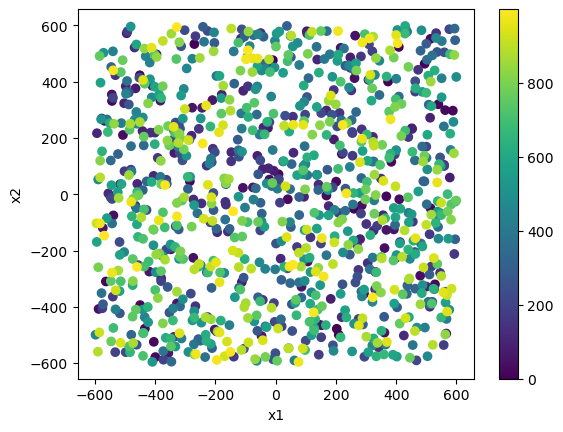

array([-9.4200679 , -4.43844443])

In [61]:
bounds = [-600, 600]
tau = 1e-8
K_u = 10
K = 1000

multi_start_optimizer(bounds, tau, K_u, K)



**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [35]:
# write your code here